# **Import Relevant Libraries**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import time
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
import shutil
from sklearn.metrics import confusion_matrix, classification_report

# **Create Dataframe from Images**

In [2]:
malaria_dir='../input/cell-images-for-detecting-malaria/cell_images/Parasitized'
healthy_dir='../input/cell-images-for-detecting-malaria/cell_images/Uninfected'
dirlist=[malaria_dir, healthy_dir]
classes=['Malaria', 'Healthy']
filepaths=[]
labels=[]
for d,c in zip(dirlist, classes):
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  27560    labels:  27560


In [3]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=pd.DataFrame(np.array(df).reshape(27560,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

Healthy    13780
Malaria    13780
Name: labels, dtype: int64


Dataset is balanced.

# **Visualize Images**

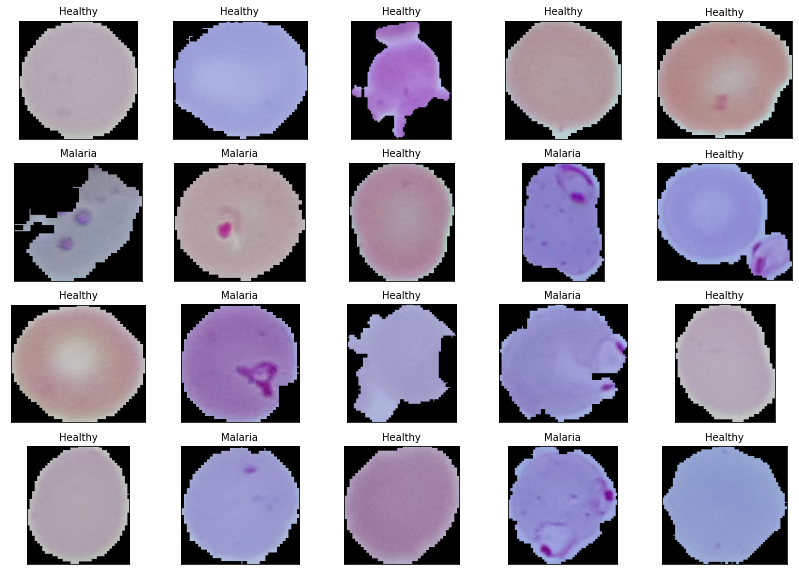

In [4]:
plt.figure(figsize=(14,10))
for i in range(20):
    random = np.random.randint(1,len(df))
    plt.subplot(4,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"file_paths"]))
    plt.title(df.loc[random, "labels"], size = 10, color = "black") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

Looks like we can do some horizontal flips in ImageDataGenerator. 

# **Splitting Dataframe into Train, Valid, and Test**

In [5]:
train_df, test_df = train_test_split(df, train_size=0.95, random_state=0)
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)

In [6]:
print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

Malaria    11783
Healthy    11780
Name: labels, dtype: int64
Healthy    1320
Malaria    1299
Name: labels, dtype: int64
Malaria    698
Healthy    680
Name: labels, dtype: int64


# **Image Data Generator**

In [7]:
target_size=(299,299)
batch_size=64

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input, horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
train_gen = train_datagen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='binary')
valid_gen = test_datagen.flow_from_dataframe(valid_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='binary')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='binary')

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="file_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 23561 validated image filenames belonging to 2 classes.
Found 2619 validated image filenames belonging to 2 classes.
Found 1378 validated image filenames belonging to 2 classes.


# **InceptionResNetV2 Model**

In [9]:
base_model = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=(299,299,3))

219062272/219055592 [==============================] - 2s 0us/step


# **Model**

In [10]:
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
lr=0.001
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])

# **Callbacks**

In [12]:
patience = 1
stop_patience = 3
factor = 0.5

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("classify_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

# **Model Training**

In [13]:
epochs = 30
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/30
369/369 [==============================] - 448s 1s/step - loss: 0.1815 - accuracy: 0.9380 - val_loss: 0.1270 - val_accuracy: 0.9675
Epoch 2/30
369/369 [==============================] - 410s 1s/step - loss: 0.1100 - accuracy: 0.9630 - val_loss: 0.1106 - val_accuracy: 0.9656
Epoch 3/30
369/369 [==============================] - 410s 1s/step - loss: 0.1069 - accuracy: 0.9632 - val_loss: 0.1060 - val_accuracy: 0.9630
Epoch 4/30
369/369 [==============================] - 410s 1s/step - loss: 0.0931 - accuracy: 0.9684 - val_loss: 0.0809 - val_accuracy: 0.9737
Epoch 5/30
369/369 [==============================] - 410s 1s/step - loss: 0.0888 - accuracy: 0.9700 - val_loss: 0.1070 - val_accuracy: 0.9614

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/30
369/369 [==============================] - 411s 1s/step - loss: 0.0769 - accuracy: 0.9740 - val_loss: 0.0758 - val_accuracy: 0.9740
Epoch 7/30
369/369 [==============================] - 411s 1s

# **Predictions**

In [14]:
best_model = model
best_model.load_weights('./classify_model.h5')
best_model.evaluate(test_gen)

22/22 [==============================] - 14s 645ms/step - loss: 0.0826 - accuracy: 0.9746


[0.08260294795036316, 0.9746008515357971]